In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

#import ROOT as r
#import warnings
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

In [3]:
xvalO = np.load("xvalO.npy")
yvalO = np.load("yvalO.npy")
xerrO = np.load("xerrO.npy")
xlowO = np.load("xlowO.npy")
xval = np.load("xval.npy")
yval = np.load("yval.npy")
xerr = np.load("xerr.npy")

toyList = np.load("toyList.npy")
lumiToyDict = np.load("lumiToyList.npy")
meanGPnom = np.load("initialGPfit.npy")
fixedHyperparams = np.load("fixedHyperparams.npy")
sigToys = np.load("signalToys.npy")
sigToysO = np.load("signalToysO.npy")

standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]

In [4]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

In [5]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  #1./(t/sqrts)
def model_5param(t, params, xErr=xerr): 
    p0, p1, p2, p3, p4 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2+p3*np.log(t/sqrts)+p4*np.log(t/sqrts)**2))*(xErr)

In [6]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                #pval = 1.-r.TMath.Gamma(nD+1.,nB)
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                #pval = pval = r.TMath.Gamma(nD,nB)
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                #zval = math.sqrt(2.)*r.TMath.ErfInverse(prob)
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
                #print "crap"
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2



def simpleLogPoisson(x, par):
    if x < 0: 
        #print "crap"
        return np.inf
    elif (x == 0): return -1.*par
    else:
        #lnpoisson = x*np.log(par)-par-r.TMath.LnGamma(x+1.)
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson
    
def makeToys(dataset, nPseudo=1000, lumi = 3.6):
    toys = []
    for n in range(nPseudo):
        pseudo = np.random.poisson(dataset*lumi/3.6)
        toys.append(pseudo)
    return toys

def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

In [7]:
def ncchi(x, nc, amp):
    return amp*ss.ncx2.pdf(x, 1., nc)
def cchi(x, amp):
    return amp*ss.chi2.pdf(x, 1.)

In [8]:
def makePrettyPlots_chi2(GPchi2, BKGchi2, title, drawchi2=False, xname=r'$\chi^{2}$', label1 = "Gaussian Process", label2 = "Fit Function"):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=30)

    lowx = min(min(GPchi2), min(BKGchi2))
    highx = max(max(GPchi2), max(BKGchi2))

    '''
        hGP = Hist(200, lowx-1, highx+1,markersize=0)
    for chi2 in GPchi2:    
        hGP.Fill(chi2)
    hBKG = Hist(200, lowx-1, highx+1,markersize=0)
    for chi2 in BKGchi2:    
        hBKG.Fill(chi2)

    hGP.fillstyle = 'solid'
    hGP.fillcolor = 'green'
    hGP.linecolor = 'black'
    hGP.linewidth = 1
    hGP.Draw("histX0")
    gphist = rplt.bar(hGP, xerr=None, yerr=None, axes=ax1, label=label1)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_title(label1, fontsize=20)
    
    if drawchi2:
        xbins=[]
        ys =[]
        for i in range(hGP.GetNbinsX()):
            xbins.append(hGP.GetBinCenter(i))
            ys.append(hGP.GetBinContent(i))
        #chiPDF=5.*ss.chi2.pdf(xbins , 1)
        
        bf_params, bf_cov = op.curve_fit(ncchi, xbins, ys)
        print "nc, amp ", bf_params
        chiPDF = bf_params[1]*ss.ncx2.pdf(xbins, 1., bf_params[0])

        ax1.plot(xbins, chiPDF, c='r', linewidth=3)
    
    hBKG.fillstyle = 'solid'
    hBKG.fillcolor = 'blue'
    hBKG.linecolor = 'black'
    hBKG.linewidth = 1
    hBKG.Draw("histX0")
    bkghist = rplt.bar(hBKG, xerr=None, yerr=None, axes=ax2, label=label2)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(xname, fontsize=30)
    ax2.set_title(label2, fontsize=20)
    
    if drawchi2:
        xbins=[]
        ys=[]
        for i in range(hBKG.GetNbinsX()):
            xbins.append(hBKG.GetBinCenter(i))
            ys.append(hBKG.GetBinContent(i))
        #chiPDF=5.*ss.chi2.pdf(xbins , 1)
        
        bf_params, bf_cov = op.curve_fit(ncchi, xbins, ys)
        print "nc, amp ", bf_params
        chiPDF = bf_params[1]*ss.ncx2.pdf(xbins, 1., bf_params[0])
        
        ax2.plot(xbins, chiPDF, c='r', linewidth=3)
    
    '''
    
    bins = np.linspace(lowx, highx, 200)
    hGP, _, _ =ax1.hist(GPchi2, bins=bins, color="b", normed=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_title(label1, fontsize=20)
    if drawchi2:
        print len(bins), len(hGP)
        bf_params, bf_cov = op.curve_fit(cchi, bins[:-1], hGP)
        print "amp ", bf_params
        chiPDF = ss.chi2.pdf(bins, 1.) #bf_params[0]*
        ax1.plot(bins, chiPDF, c='r', linewidth=3)
    
    
    hBKG, _, _ =ax2.hist(BKGchi2, bins=bins, color='g', normed=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(xname, fontsize=30)
    ax2.set_title(label2, fontsize=20)
    if drawchi2:
        bf_params, bf_cov = op.curve_fit(cchi, bins[:-1], hBKG)
        print "amp ", bf_params
        #chiPDF = bf_params[1]*ss.ncx2.pdf(bins, 1., bf_params[0])
        chiPDF = ss.chi2.pdf(bins, 1.) #bf_params[0]*
        ax2.plot(bins, chiPDF, c='r', linewidth=3)

    plt.show()




In [9]:
def logLike_gpLikeFF(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += -simpleLogPoisson(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  

class logLike_3ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_3ff_sig:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, N):
        params = p0, p1, p2
        nSignal = N
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf
        
class logLike_5ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, p3, p4):
        params = p0, p1, p2, p3, p4
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_5ff_sig:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, p3, p4, N):
        params = p0, p1, p2, p3, p4
        nSignal = N
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf

In [10]:
def fit_3ff(lnprob, Print = True):
  #  np.random.seed(1234)
    bestval = np.inf
    bestargs = (0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, 
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1 

    if Print:
        print "min LL",bestval
        print "best fit vals", bestargs
    return bestval, bestargs

def fit_3ff_sig(lnprob, Print = True):
  #  np.random.seed(1234)
    bestval = np.inf
    bestargs = (0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        init3 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, N = init3,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_N = 1e-4,
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.), limit_N = (0, 100))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

def fit_5ff(lnprob, Print = True):
  #  np.random.seed(1234)
    bestval = np.inf
    bestargs = (0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, p3 = init3, p4 = init4,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_p3 = 1e-2, error_p4 = 1e-2,
                  limit_p0 = (0, 10), limit_p1 = (-20, 20), limit_p2 = (-20, 20), 
                   limit_p3 = (-20, 20), limit_p4 = (0, 50))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL",bestval
        print "best fit vals", bestargs
    return bestval, bestargs

def fit_5ff_sig(lnprob, Print = True):
  #  np.random.seed(1234)
    bestval = np.inf
    bestargs = (0., 0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        init5 = np.random.random() * 1
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, p3 = init3, p4 = init4, N = init5,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_p3 = 1e-2, error_p4 = 1e-2, error_N = 1e-4,
                  limit_p0 = (0, 10), limit_p1 = (-20, 20), limit_p2 = (-20, 20), 
                   limit_p3 = (-20, 20), limit_p4 = (-20, 20), limit_N = (0, 100))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [11]:
def model_gp(params, t, xerr=xerr): 
    #global xerr
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp_tempSig_fixedH:
    def __init__(self, x, y, xerr, sigTemp):
        self.x = x
        self.y = y
        self.xerr = xerr
        self.sigTemp = sigTemp
    def __call__(self, N):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr)-N*self.sigTemp)
        except:
            return np.inf        
        
def fit_gp_tempSig_fixedH_minuit(lnprob, Print = True):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, 
                   N = init0, error_N = 1e-4, limit_N = (0, 100)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs




In [29]:
btime=time.time()


listGP_N=[]
LLlistGP_b={}
LLlistGPP_b={}
for pSet in standardParamSets:
    n, m, w = pSet
    print pSet
    LLlistGP_b[m]=[]
    LLlistGPP_b[m]=[]
    listGP_toyN=[]
        
    for itoy, toy in enumerate(toyList):
        if not itoy%500: 
            np.save("LLH_GP", LLlistGP_b)
            print itoy
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        signalTemplate = sigToys[()][m][itoy]
        ydata = ytoy + signalTemplate

        signalTemplateO = sigToysO[()][m][itoy]
        ydataO = toy + signalTemplateO

        #BACKGROUND ONLY FIT GP
        if not itoy%500:
            pgpb_stime = time.time()
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp1 = george.GP(kernel1)
        gp1.compute(xtoy, np.sqrt(ydata))
        meanGP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        meanGP1 = meanGP1p+ model_3param(xvalO,(p0,p1,p2),xerrO)
        gplike = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
        if not itoy%500:
            pgpb_etime = time.time()
            print "background only time:", pgpb_etime-pgpb_stime

        #BACKGROUND+SIGNAL FIT GP
        if not itoy%500:
            pgpsb_stime = time.time()
        lnProb = logLike_gp_tempSig_fixedH(xtoy,ydata, xtoyerr, signalTemplate)
        bestval, best_fit_new = fit_gp_tempSig_fixedH_minuit(lnProb, False)
        mu = best_fit_new[0]
        listGP_toyN.append(mu*n)
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate, xvalO)
        meanGP = meanGPp+ model_3param(xvalO,(p0,p1,p2),xerrO)
        meanGPsig = meanGP+mu*signalTemplateO
        gplikeSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate)
        if not itoy%500:
            pgpsb_etime = time.time()
            print "background + signal time:", pgpsb_etime - pgpsb_stime
        
        LLlistGP_b[m].append(-2*(gplike-gplikeSig))
        LLlistGPP_b[m].append(-2*(-logLike_gpLikeFF(ydataO, meanGP1)+logLike_gpLikeFF(ydataO, meanGPsig)))


    listGP_N.append([np.mean(np.array(listGP_toyN)),np.var(np.array(listGP_toyN)), np.std(np.array(listGP_toyN))])
etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"   

(1500, 2000, 250)
0
background only time: 0.0503449440002
background + signal time: 0.0488810539246
500
background only time: 0.0436098575592
background + signal time: 0.219398021698
1000
background only time: 0.00496101379395
background + signal time: 0.170882940292
1500
background only time: 0.0412290096283
background + signal time: 0.0449380874634
2000
background only time: 0.0614278316498
background + signal time: 0.0943031311035
2500
background only time: 0.0385000705719
background + signal time: 0.145650148392
3000
background only time: 0.00470209121704
background + signal time: 0.0530941486359
3500
background only time: 0.00456619262695
background + signal time: 0.0545167922974
4000
background only time: 0.00496792793274
background + signal time: 0.0769810676575
4500
background only time: 0.005530834198
background + signal time: 0.0588791370392
5000
background only time: 0.00471591949463
background + signal time: 0.125434875488
5500
background only time: 0.00554418563843
backgro

In [32]:
btime=time.time()

listSTD_N=[]
LLlistSTD3_b={}
#LLlistSTD5_b={}
for pSet in standardParamSets:
    n, m, w = pSet
    print pSet
    LLlistSTD3_b[m]=[]
    #LLlistSTD5_b[m]=[]
    listSTD_toyN=[]

        
    for itoy, toy in enumerate(toyList[:1000]):
        if not itoy%500: 
            #np.save("LLH_3Param", LLlistSTD3_b)
            #np.save("LLH_5Param", LLlistSTD5_b)
            print itoy
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        
        signalTemplate = sigToys[()][m][itoy]
        ydata = ytoy + signalTemplate

        signalTemplateO = sigToysO[()][m][itoy]
        ydataO = toy + signalTemplateO
        
        #######################################################
        if not itoy%500:
            p3b_stime = time.time()
        #BACKGROUND ONLY 3 PARAM FIT
        lnProb = logLike_3ff(xvalO, ydataO ,xerrO)
        ll_b3, best_fit_params = fit_3ff(lnProb, False)
        if not itoy%500:
            p3b_etime = time.time()
            print "background only 3 param: ", p3b_etime - p3b_stime
        
        #BACKGROUND+SIGNAL 3 PARAM FIT
        if not itoy%500:
            p3sb_stime = time.time()
        lnProb = logLike_3ff_sig(xvalO,ydataO,xerrO, signalTemplateO)
        ll_sb3, best_fit_params = fit_3ff_sig(lnProb, False)
        a1, a2, a3, mu3 = best_fit_params

        LLlistSTD3_b[m].append(-2*(-ll_b3+ll_sb3))
        listSTD_toyN.append(mu3*n)
        if not itoy%500:
            p3sb_etime = time.time()
            print "s+b 3 param: ", p3sb_etime - p3sb_stime

            
        '''
        #BACKGROUND ONLY 5 PARAM FIT
        if not itoy%500:
            p5b_stime = time.time()
        lnProb = logLike_5ff(xvalO, ydataO ,xerrO)
        ll_b5, best_fit_params = fit_5ff(lnProb, False)
        if not itoy%500:
            p5b_etime = time.time()
            print "background only 5 param: ", p5b_etime - p5b_stime
            
        #BACKGROUND+SIGNAL 5 PARAM FIT
        if not itoy%500:
            p5sb_stime = time.time()
        lnProb = logLike_5ff_sig(xvalO,ydataO,xerrO, signalTemplateO)
        ll_sb5, best_fit_params = fit_5ff_sig(lnProb, False)
        a1, a2, a3, a4, a5, mu5 = best_fit_params


        LLlistSTD5_b[m].append(-2*(-ll_b5+ll_sb5))
        if not itoy%500:
            p5sb_etime = time.time()
            print "s+b 3 param: ", p5sb_etime - p5sb_stime
        '''

    listSTD_N.append([np.mean(np.array(listSTD_toyN)),np.var(np.array(listSTD_toyN)), np.std(np.array(listSTD_toyN))])     
            
etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"   

(1500, 2000, 250)
0
background only 3 param:  5.6673681736
s+b 3 param:  10.5876150131
500
background only 3 param:  4.12586808205
s+b 3 param:  5.95565199852
(750, 2500, 250)
0
background only 3 param:  1.25636720657
s+b 3 param:  5.23496794701
500
background only 3 param:  2.63300704956
s+b 3 param:  4.08397507668
(200, 3000, 250)
0
background only 3 param:  2.7840590477
s+b 3 param:  4.1855738163
retry number =  5
500
background only 3 param:  1.225304842
s+b 3 param:  5.57587122917
(75, 3500, 250)
0
background only 3 param:  2.67981410027
s+b 3 param:  7.50129699707
500
background only 3 param:  5.1087501049
s+b 3 param:  16.7705960274
(50, 4000, 250)
0
background only 3 param:  4.12520384789
s+b 3 param:  7.08687496185
500
background only 3 param:  5.37456011772
s+b 3 param:  7.0667848587
(25, 4500, 250)
0
background only 3 param:  2.72071409225
s+b 3 param:  4.82759618759
500
background only 3 param:  2.01459002495
s+b 3 param:  7.60911893845
(20, 5000, 250)
0
background only 3 p

In [73]:
print len(toyList)
#print len(LLlistSTD5_b[3500])
print len(LLlistSTD3_b[3500])
print len(LLlistGP_b[3500])
print len(gp)

#np.save("GP_N_templateSignal", listGP_N)
#msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
#for m in msignals:
#    np.save("LLHR_GP_other_"+str(m)+"_withSignal", LLlistGPP_b[m])

10000
1000
10000
10000


10000


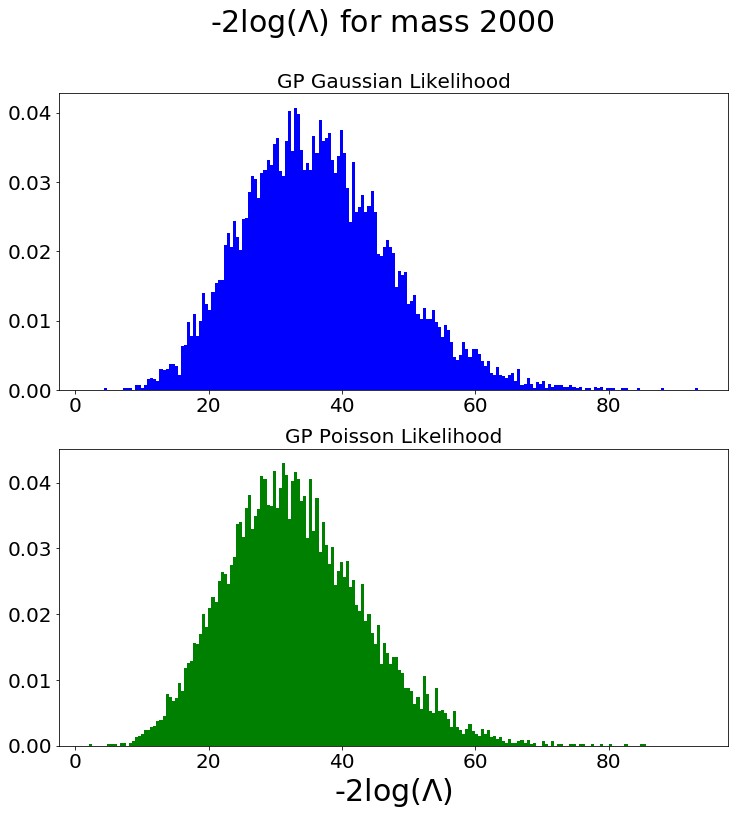

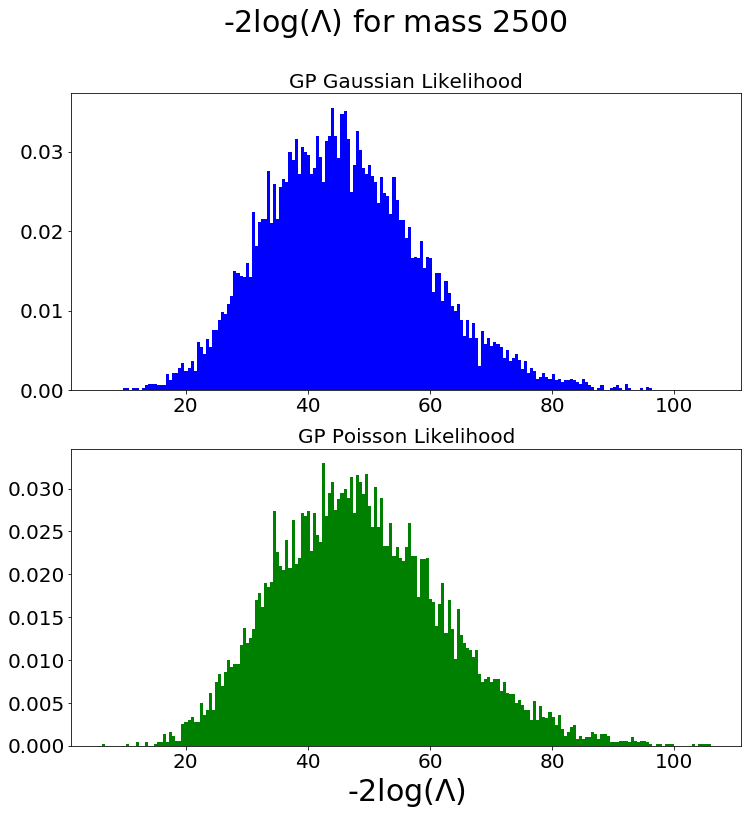

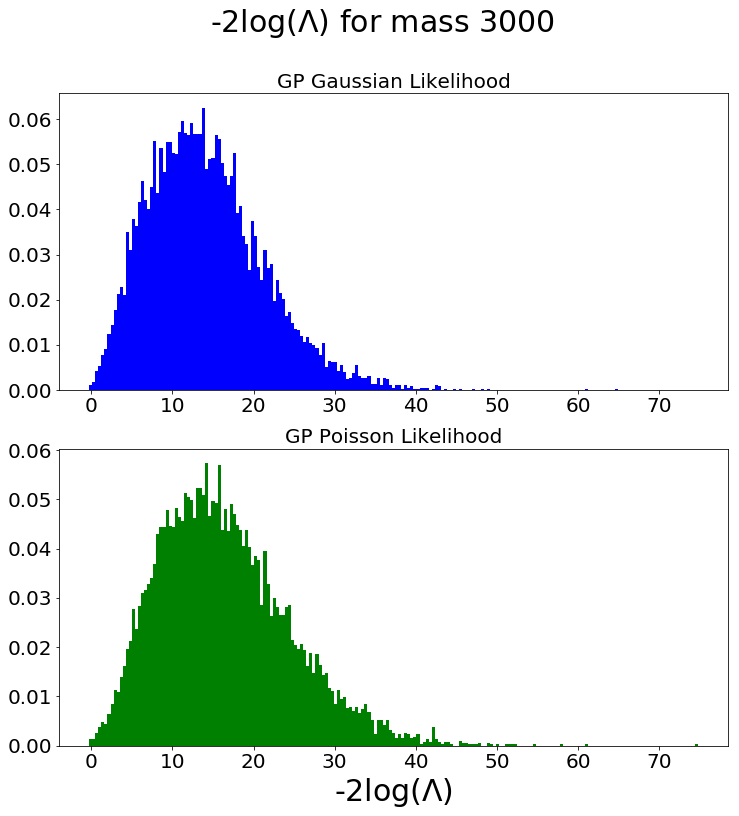

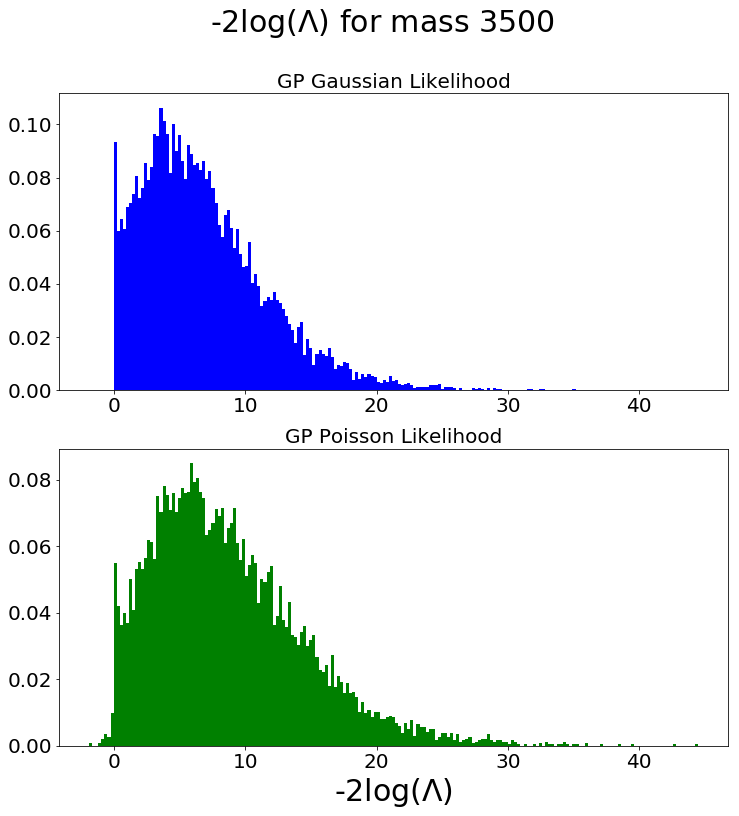

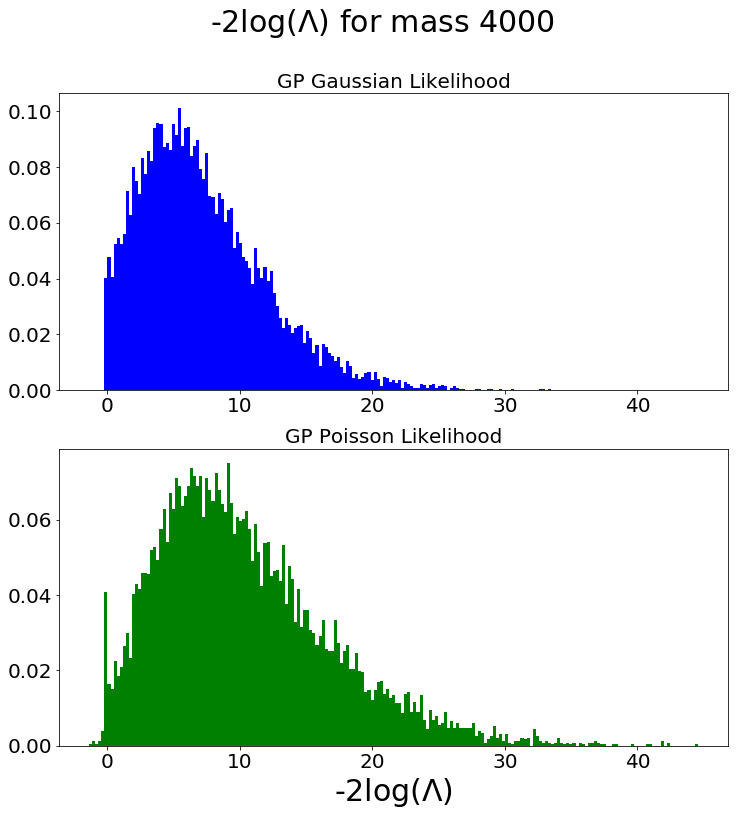

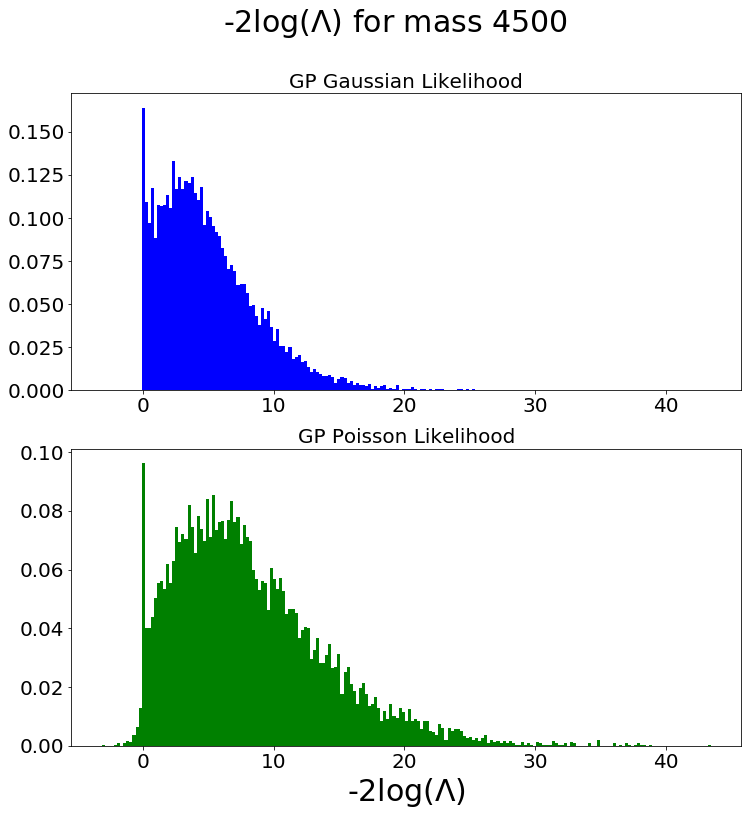

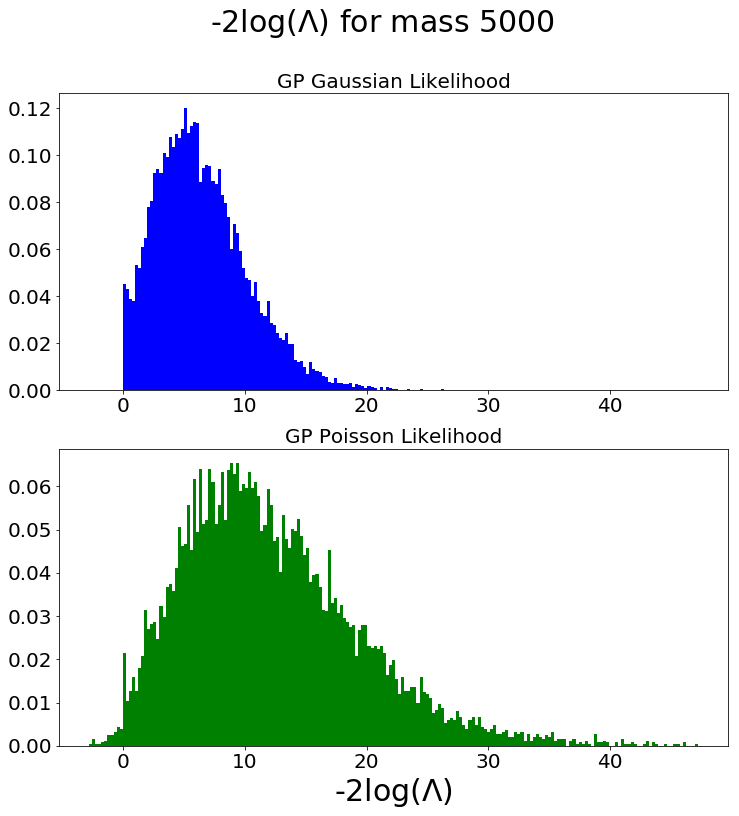

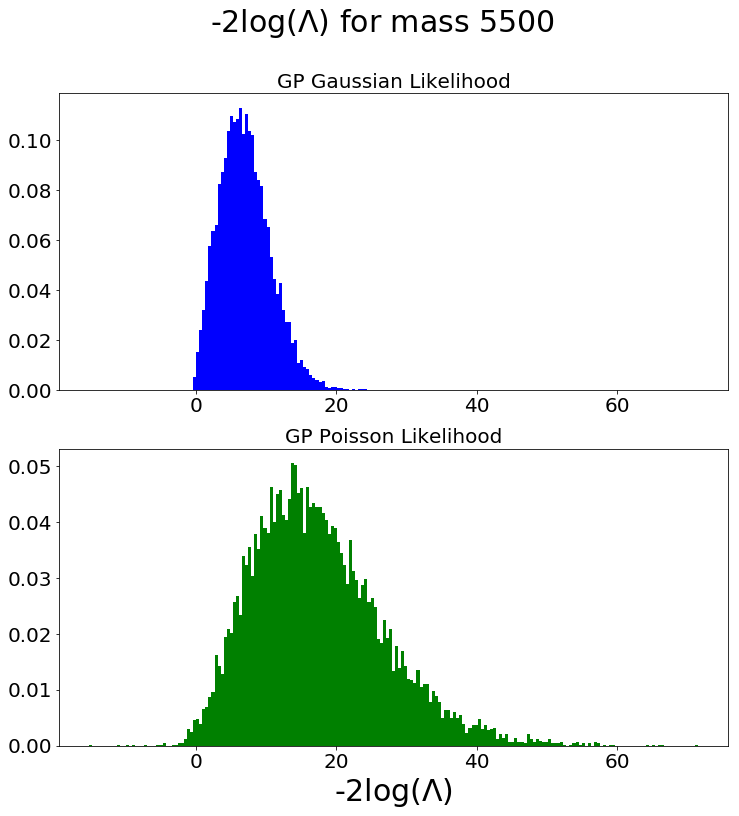

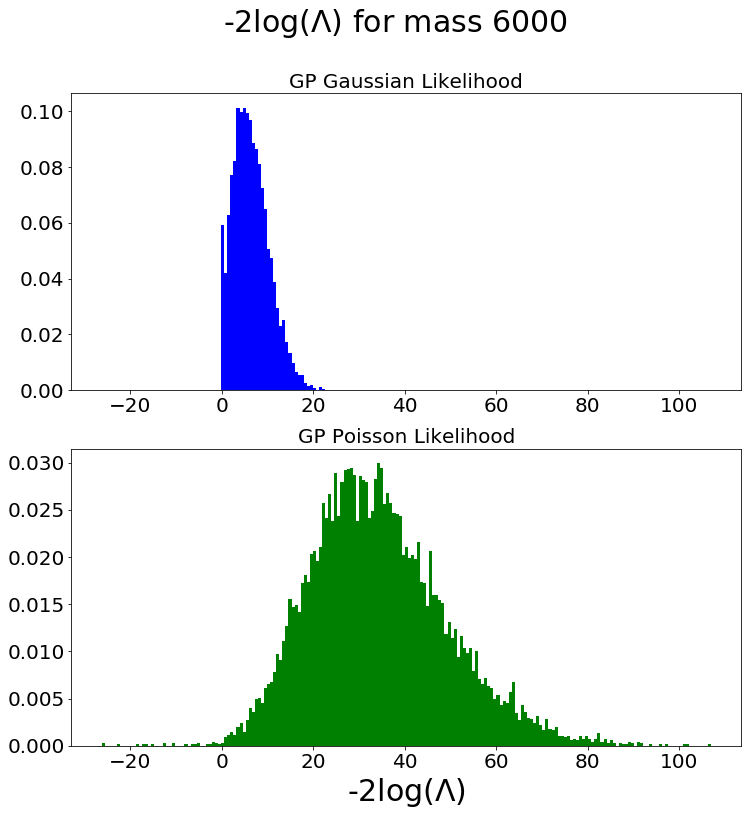

In [59]:
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
#msignals=[3500]
print len(LLlistGP_b[3500])
GPlistb=[]
GPlistPb=[]
for m in msignals:
    gp = LLlistGP_b[m]
    gp_p = LLlistGPP_b[m]
    '''
    for bi, b in enumerate(gp):
        if b < 0: 
            print "REMOVING", b
            gp.pop(bi)
    for bi, b in enumerate(gp_p):
        if b < 0: 
            print "REMOVING", b
            gp_p.pop(bi)
    '''

            
    GPlistb.append([np.mean(np.array(gp)), np.std(np.array(gp))/np.sqrt(len(gp))])
    GPlistPb.append([np.mean(np.array(gp_p)), np.std(np.array(gp_p))/np.sqrt(len(gp_p))])

    label = r"-2log($\Lambda$) for mass "+str(int(m))
    makePrettyPlots_chi2(gp, gp_p, label, drawchi2=False, xname = r"-2log($\Lambda$)", label1 ="GP Gaussian Likelihood", label2 = "GP Poisson Likelihood")

1000


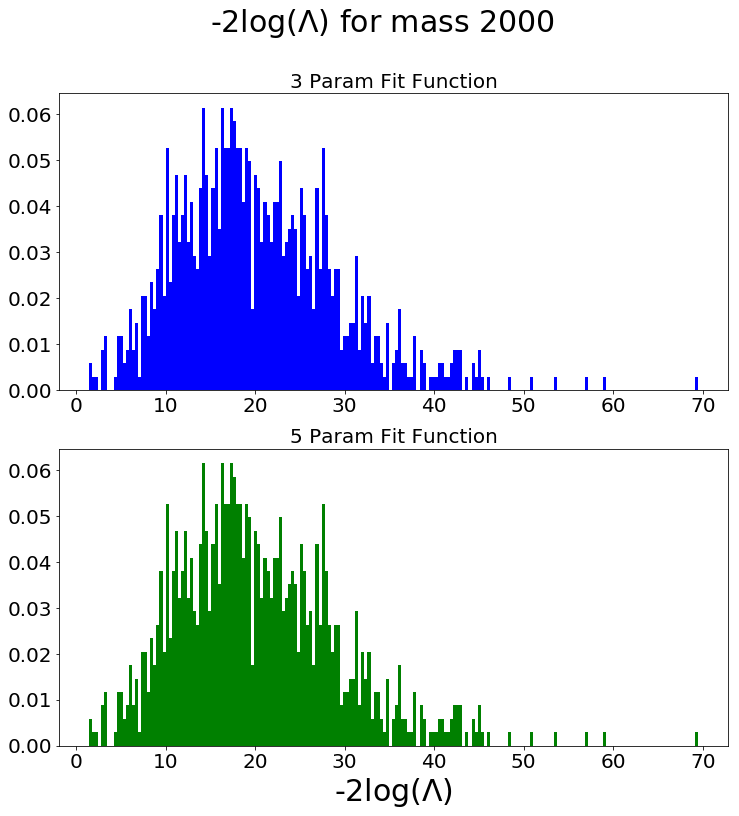

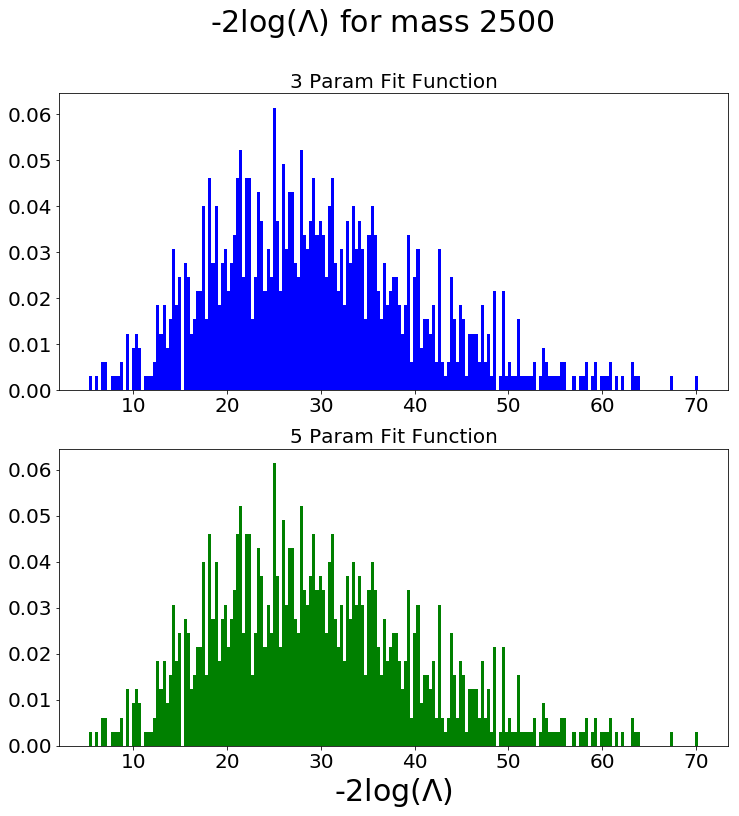

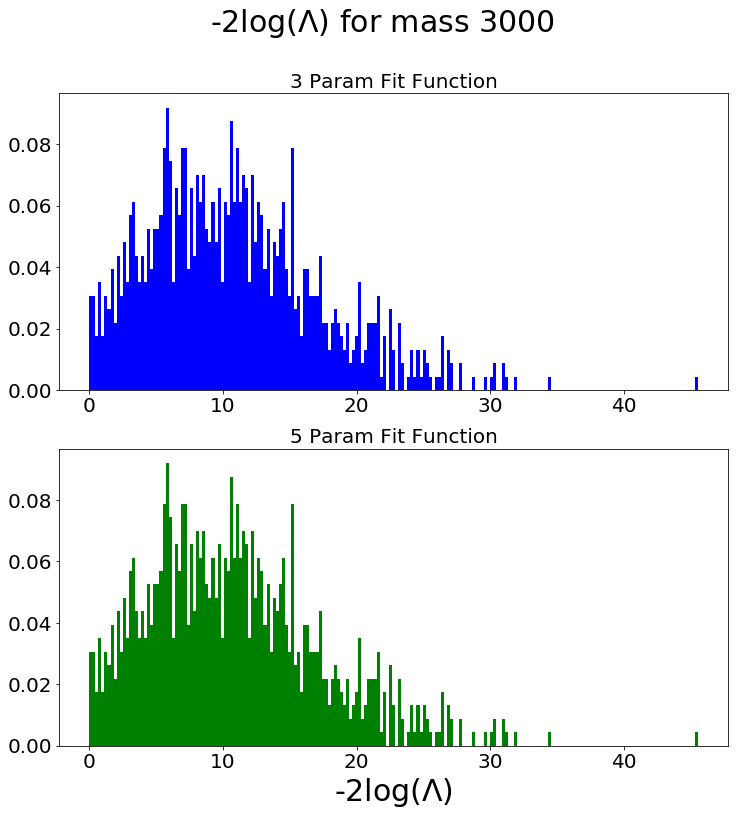

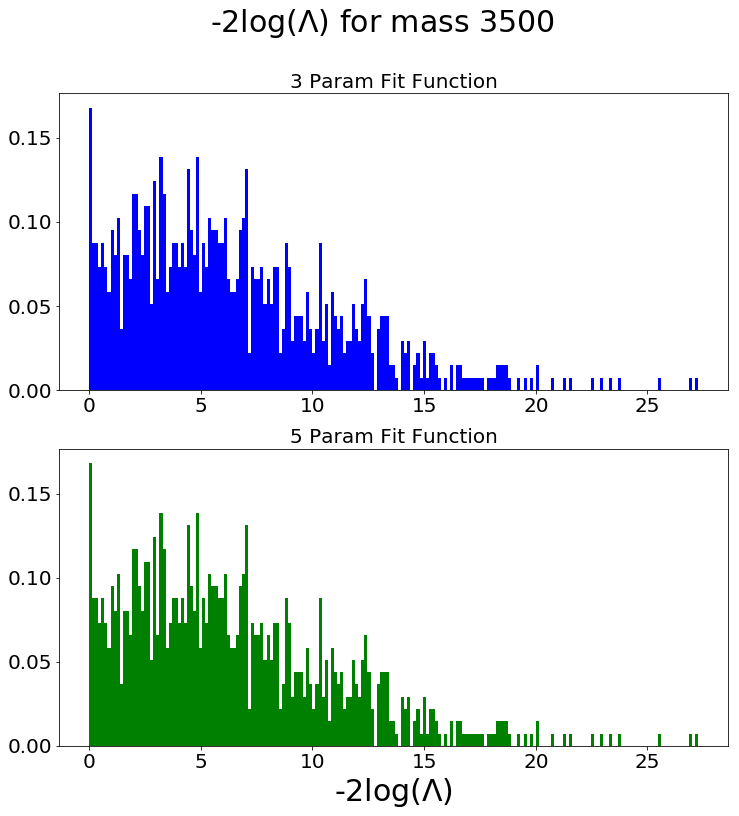

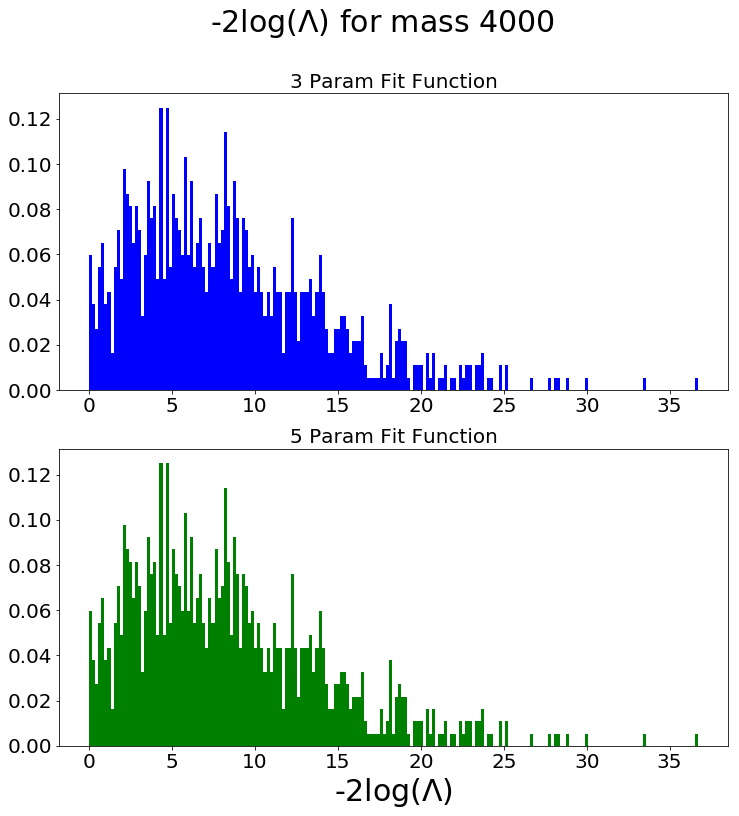

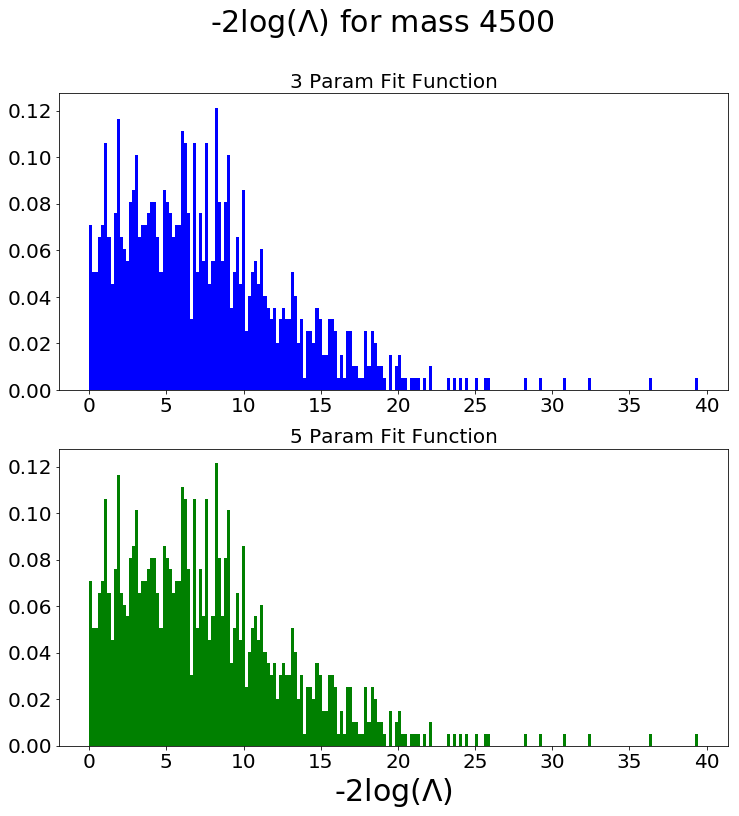

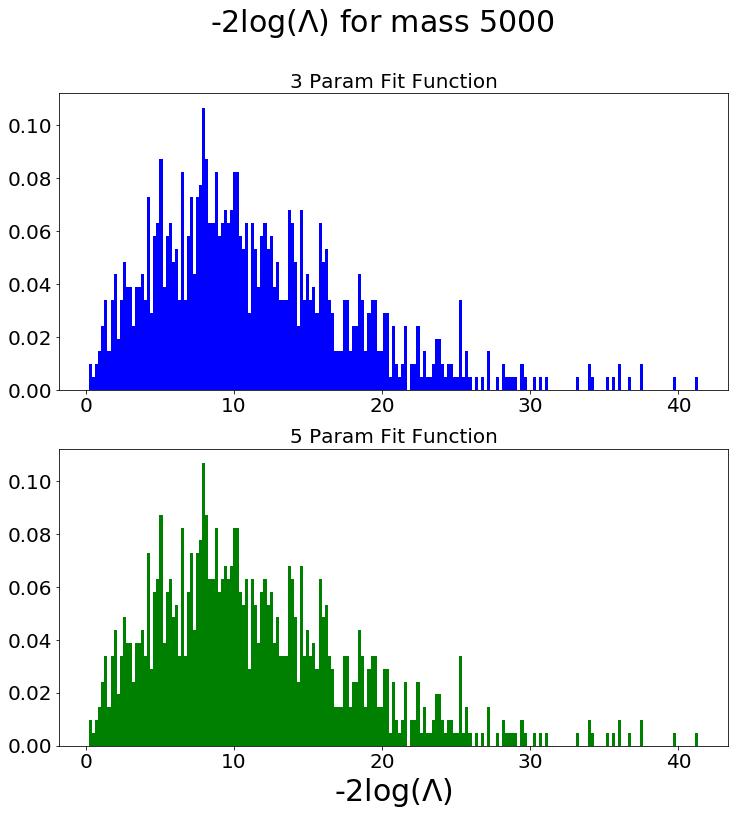

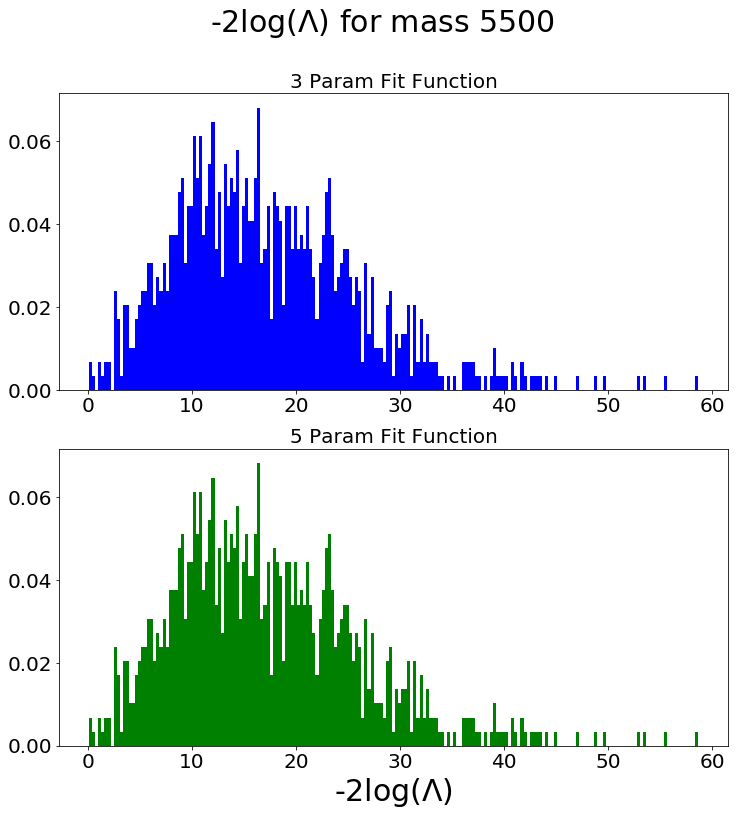

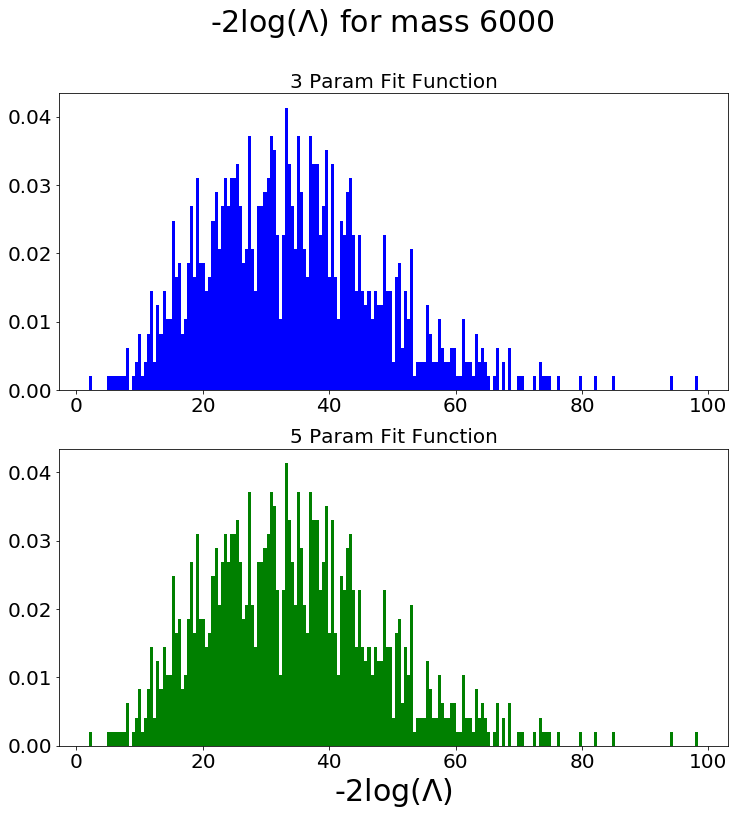

In [64]:
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
#msignals=[3500]
print len(LLlistSTD3_b[3500])
BKGlist3b=[]
#BKGlist5b=[]
for m in msignals:
    std3 = LLlistSTD3_b[m]
    #std5 = LLlistSTD5_b[m]
    
    for bi, b in enumerate(std3):
        if abs(b) > 100 : 
            print "REMOVING", b
            std3.pop(bi)
  #  for bi, b in enumerate(std5):
  #      if b < 0: 
  #          print "REMOVING", b
  #         std5.pop(bi)
    

   # print std5        
    BKGlist3b.append([np.mean(np.array(std3)), np.std(np.array(std3))/np.sqrt(len(std3))])
    #BKGlist5b.append([np.mean(np.array(std5)), np.std(np.array(std5)/np.sqrt(len(std5)))])
    label = r"-2log($\Lambda$) for mass "+str(int(m))
    makePrettyPlots_chi2(std3, std3, label, drawchi2=False, xname =r"-2log($\Lambda$)", label1="3 Param Fit Function", label2 = "5 Param Fit Function" )


0.111045883458


(1, 400)

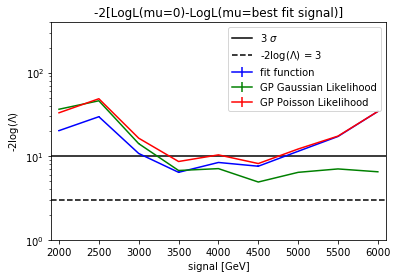

In [65]:
print GPlistb[0][1]

msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
plt.figure()
plt.errorbar(msignals, [BKGlist3b[i][0] for i in range(len(msignals))], yerr = [BKGlist3b[i][1] for i in range(len(msignals))], color="b", label="fit function")
plt.errorbar(msignals, [GPlistb[i][0] for i in range(len(msignals))], yerr = [GPlistb[i][1] for i in range(len(msignals))], color="g", label="GP Gaussian Likelihood")
plt.errorbar(msignals, [GPlistPb[i][0] for i in range(len(msignals))], yerr = [GPlistPb[i][1] for i in range(len(msignals))], color="r", label="GP Poisson Likelihood")
plt.plot([1900,6100], 10*np.ones(2), c='black', label=r'3 $\sigma$')
plt.plot([1900,6100], 3*np.ones(2), c='black', ls='--', label=r"-2log($\Lambda$) = 3")

plt.xlabel("signal [GeV]")
plt.yscale('log', nonposy="clip")
plt.xlim([1900, 6100])
plt.title("-2[LogL(mu=0)-LogL(mu=best fit signal)]")
plt.ylabel(r"-2log($\Lambda$)")
plt.legend(loc=1)
plt.ylim([1, 400])